# TensorFlow / Keras Tutorial
## Statistical Learning FA 20

This notebook will walk you through how to train a deep neural network using the TensorFlow. **Some code blocks you can run as-is, but for others you will need to write some code to complete it. Pay attention to the instructions as there are a few practice questions that correspond to the output from this tutorial.**

TensorFlow (TF) is a open source library for training neural nets, that is used in research as well as production systems. We will interact with TF using a high-level library built on top of it, called Keras.  

Like scikit-learn, Keras makes it easier to fit complex models without worrying too much about the details. We'll be able to use Keras to fit all of the neural network models from this course. 

If you want to learn more beyond this tutorial, check out the beginner guides at https://www.tensorflow.org/guide/keras, or the documentation at https://keras.io.

We'll start by loading some of the typical packages from `numpy`, `pandas`, and `sklearn`. Then we'll import a few of the necessary functions from `tensorflow` and `keras`.  

In [38]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

# TensorFlow / Keras functions
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Generate and preprocess data

Next we'll generate some training data using the `make_classification` function in scikit-learn. 

Since neural networks are most effective with lots of training data, we'll create a dataset with 10,000 observations and 100 features. Of these 100 features, 50 will be informative, 10 will be redundant (linear combinations of informative features), and the rest will be random. 

To keep it simple we'll keep the classes balance (50/50) so that we can just use accuracy for our metric. 

We'll also ensure that `y` is a column vector which is required for models in Keras.

In [39]:
X, y = make_classification(n_samples=10000, n_features=100, n_informative=50, n_redundant=10, random_state=2019)
y = y.reshape(-1, 1)

In [40]:
print('X shape:', X.shape)
print('y shape:', y.shape)
print('y:', y)

X shape: (10000, 100)
y shape: (10000, 1)
y: [[0]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]


Next we'll split the data into 3 sets for training, validation and testing, using a 60/20/20 split. 
We want to use the training set to fit the model, the validation set to evaluate how well it's fitting, and the test set for a final evaluation of the model. 

Since the `train_test_split` function only creates two sets, we'll do this in 2 stages, specifying an integer for number of validation and testing samples (20%). 

In [41]:
n = X.shape[0]  # total sample size, n
n20 = int(.2*n)  # 20% of n
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n20, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=n20, random_state=2)

Let's check that it worked as intended:

In [42]:
print('X shapes: ', X_train.shape, X_valid.shape, X_test.shape)
print('y shapes: ', y_train.shape, y_valid.shape, y_test.shape)

X shapes:  (6000, 100) (2000, 100) (2000, 100)
y shapes:  (6000, 1) (2000, 1) (2000, 1)


## Fit a baseline model using Logistic regression
Before we start training a neural network, we should start with a simple model to use as a baseline to evaluate how well we're doing.

We'll train the model using the training set and evaluate on the test set.
Note that we're not using the validation set here. 
Since we'll only use the training set for the neural network, we'll leave it out here for a fair comparison.

In [43]:
lr = LogisticRegressionCV()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, lr_preds)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Logistic regression accuracy: 0.804


## Model 1: Fit a neural network with 1 hidden layer

To fit a simple model, we'll use the `Sequential` class from Keras.   

From here we can add `Dense` layers, meaning they are fully connected to the layer before and after it.  
The order that we add layers determines the structure of the network.


Within each layer we need to specify the number of units or neurons and an activation function for the output from that layer.  
Some common activation functions include: `'sigmoid'`, `'relu'`, `'softmax'`, `'tanh'`, and `'linear'`.  
We should also specify the format of the features for the first layer, which is a tuple in the format: `(p, )`. 

The following code creates a network with one hidden layer that has 50 neurons. The output of those neurons is passed through a ReLU activation function to the output layer. 

The output layer just has one neuron with a sigmoid activation function so that it can convert the outputs from the previous layer to a probability, since this is a binary classification problem. 

In [44]:
model1 = Sequential()
model1.add(Dense(50, activation='relu', input_shape=(X.shape[1], )))
model1.add(Dense(1, activation='sigmoid'))

We can inspect the model architecture with the `.summary()` method. This tells us how many parameters are being fit for each layer and for the entire network.


In [45]:
model1.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 51        
Total params: 5,101
Trainable params: 5,101
Non-trainable params: 0
_________________________________________________________________


Notice that for the first layer there are 5,050 parameters. This is because each neuron learns a weight for each of the 100  features. So there are 50*100=5,000 weight parameters, plus another 50 weights for the bias. 

The bottom of the chart tells us how many total parameters there are in this model ("Total params"). 

### Practice question 1: How many total parameters need to be trained for this model?
Enter your answer in for the practice problem in Canvas. 

### Training
Now that the architecture of our model is set up, we can start training.  
First we need to compile our model. At this stage we will specify our loss function, the optimizer and additional metrics we want to track. 

For this example, we'll use the `'adam'` optimizer, but other choices include `'rmsprop'` and `'sgd'`.

Since this is a classification problem, we'll use `'binary_crossentropy'` for a loss function. Other popular loss functions include `'mean_squared_error'`, `'mean_absolute_error'` and `'categorical_crossentropy'`.

Since this loss function is hard to interpret, we'll also ask the model to compute the `'accuracy'`. 

In [9]:
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

Next we can fit fit our model to the training data. Throughout the training process it will print the loss function and metrics for both the training set and validation set. 

We also need to specify how long to train the model with the number of `epochs`, and how many samples to use through each phase of backpropagatoin - the `'batch_size'`. For this model we'll use 50 epochs with a batch size of 100. 

Here we will also specify which validation set to use. 

When I call the `fit` method, I also assign it to a variable called `history`. This is optional, but it allows us to examine the loss and metrics for each epoch (see below). 

In [10]:
history = model1.fit(X_train, y_train, epochs=50, batch_size=100,
                     validation_data=(X_valid, y_valid))

Train on 6000 samples, validate on 2000 samples
Epoch 1/50
6000/6000 [==============================] - 1s 160us/sample - loss: 2.2240 - accuracy: 0.5865 - val_loss: 0.6508 - val_accuracy: 0.7605
Epoch 2/50
6000/6000 [==============================] - 0s 22us/sample - loss: 0.5419 - accuracy: 0.7823 - val_loss: 0.4254 - val_accuracy: 0.8300
Epoch 3/50
6000/6000 [==============================] - 0s 22us/sample - loss: 0.3644 - accuracy: 0.8453 - val_loss: 0.3427 - val_accuracy: 0.8605
Epoch 4/50
6000/6000 [==============================] - 0s 22us/sample - loss: 0.2857 - accuracy: 0.8818 - val_loss: 0.2918 - val_accuracy: 0.8840
Epoch 5/50
6000/6000 [==============================] - 0s 22us/sample - loss: 0.2359 - accuracy: 0.9080 - val_loss: 0.2618 - val_accuracy: 0.8945
Epoch 6/50
6000/6000 [==============================] - 0s 22us/sample - loss: 0.2028 - accuracy: 0.9237 - val_loss: 0.2364 - val_accuracy: 0.9060
Epoch 7/50
6000/6000 [==============================] - 0s 22us/sampl

As you can see the training loss decreases as the epochs increase, but the validation loss decreases up to a certain point because it starts to overfit.

CAUTION: If you want to refit the model, you need to call `Sequential()` again and start from the beginning, otherwise it will start training from where it left off.  

We can evaluate this model on the test set with the `.evaluate()` method. Compare this to the accuracy from the logistic regression model.

In [11]:
model1.evaluate(X_test, y_test)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.1525063201636076, 0.9545]

We can also plot the accuracy and loss during training, by calling the history attribute.

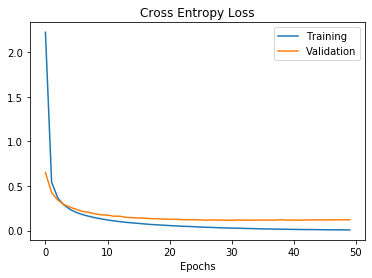

In [12]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.legend()
plt.show()

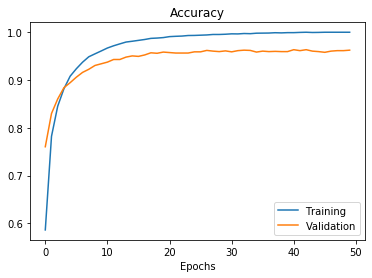

In [13]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.legend()
plt.show()

If we wanted to get predictions from the model we can use the `predict` method. Since the last layer was a sigmoid activation function, the outputs are probabilities between 0 and 1. 

In [14]:
model1.predict(X_test)

array([[6.5529346e-04],
       [3.0193329e-03],
       [1.3142824e-04],
       ...,
       [3.2305717e-05],
       [0.0000000e+00],
       [9.9759775e-01]], dtype=float32)

## Model 2: Create a deep network with 3 hidden layers 
Now that we've seen the basics of how to train a neural network let's start adding some more complexity. 

**Assignment: add 2 more hidden layer to model 1. Each should have 10 neurons and a ReLU activation function.**  
Note that you don't need to specify the input shape for the other layers because it's inferred from the previous layer.

The previous model is copied below for your convenience. 

After completing the model, call `.summary()` on this model to inspect the structure.

In [37]:
model2 = Sequential()
model2.add(Dense(50, activation='relu', input_shape=(X.shape[1], )))
# ADD 2 HIDDEN LAYERS HERE
model2.add(Dense(1, activation='sigmoid'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(10, activation='relu'))

model2.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 51        
_________________________________________________________________
dense_69 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_70 (Dense)             (None, 10)                110       
Total params: 5,231
Trainable params: 5,231
Non-trainable params: 0
_________________________________________________________________


### Practice question 2: How many total parameters need to be trained for this model?  
Enter your answer for the practice problem in Canvas.

Finish training the model using the same steps as before. 

Try exploring different tuning parameters, specifically changing:
 - Number of epochs
 - Batch size
 - Number of neurons per layer
 - Activation functions

In [ ]:
# COMPILE THE MODEL

# FIT THE MODEL TO THE TRAINING DATA

# EVALUATE THE MODEL ON THE TEST SET

# PLOT THE CURVES FOR ACCURACY AND LOSS

## Models 3-5: Add regularization
Since neural networks are so powerful, they are prone to overfitting on the training set. There are a few common methods to avoid this. 

### Dropout
The first is adding dropout. We do this by adding a `Dropout` layer after the layer we want to apply dropout to, and specify the dropout rate. 

For example, the following network has 2 hidden layers, and applies 50% dropout after each layer. This doesn't add any new parameters to the model, only an operation to be performed between layers. 

**Practice: Train the model with dropout, and experiment with different dropout rates.**

In [48]:
model3 = Sequential()
model3.add(Dense(100, activation='relu', input_shape=(X.shape[1], )))
model3.add(Dropout(rate=.5))
model3.add(Dense(50, activation='relu'))
model3.add(Dropout(rate=.5))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 51        
Total params: 15,201
Trainable params: 15,201
Non-trainable params: 0
_________________________________________________________________



### Parameter norm penalties
Another regularization method is to add L1 or L2 penalties to the weights. This is done with the `kernel_regularizer` parameter.  

Here's an example that adds an L1 penalty to the first hidden layer, and an L2 penalty to the second. The number specifies how penalty should be applied (larger = more regularization).

**Practice: Train the model with different penalty parameters.**

In [ ]:
model4 = Sequential()
model4.add(Dense(100, activation='relu', input_shape=(X.shape[1], ), 
                 kernel_regularizer=keras.regularizers.l1(.001)))
model4.add(Dense(50, activation='relu',
                 kernel_regularizer=keras.regularizers.l2(.001)))
model4.add(Dense(1, activation='sigmoid'))
model4.summary()

### Early stopping
The last regularization method we discussed is early stopping. 

We can implement this with a "callback", or a function that is called during training.   
You need to specify the `patience` - how many epochs should we allow the model to increase validation loss before stopping.  

Notice how early stopping was added to the code below and how it's passed to the `fit()` method.  
Here we use a patience of 3, and let it run for 100 epochs. The training should stop once the validation loss stops decreasing. 

In [ ]:
model5 = Sequential()
model5.add(Dense(100, activation='relu', input_shape=(X.shape[1], )))
model5.add(Dense(50, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))
model5.summary()

model5.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model5.fit(X_train, y_train, epochs=100, batch_size=100,
          validation_data=(X_valid, y_valid),
          callbacks=[early_stopping])


In [50]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(100, )))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_89 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_90 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 33        
Total params: 23,297
Trainable params: 23,297
Non-trainable params: 0
_________________________________________________________________
